In [ ]:
pip install stable-baselines3[extra]

In [14]:
(8 - 10) / 10

-0.2

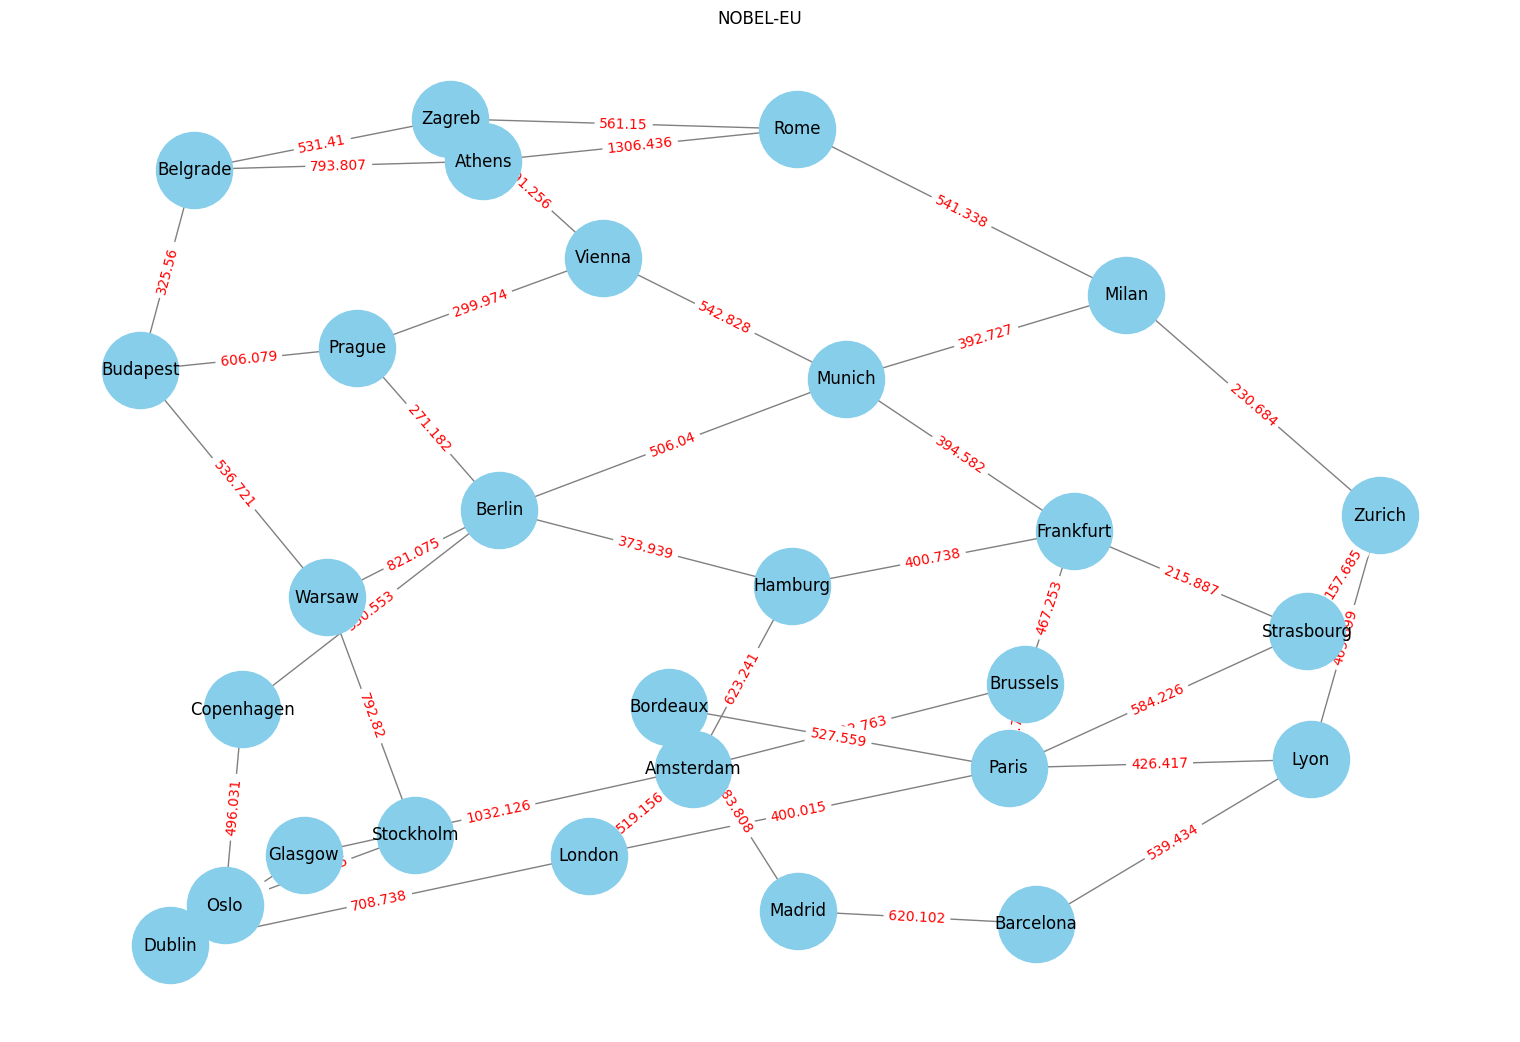

Using cpu device
Logging to ./ppo_masked_tensorboard/PPO_14


ValueError: setting an array element with a sequence. The requested array would exceed the maximum number of dimension of 1.

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from typing import Tuple
import gymnasium as gym

# sb3_contrib: Maskable PPO
from sb3_contrib import MaskablePPO
from sb3_contrib.common.maskable.callbacks import MaskableEvalCallback

# Callbacks e ferramentas do Stable Baselines
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv

# Para TensorBoard
from torch.utils.tensorboard import SummaryWriter

# Imports do optical_networking_gym
from optical_networking_gym.wrappers.qrmsa_gym import QRMSAEnvWrapper
from optical_networking_gym.topology import Modulation, get_topology

def define_modulations() -> Tuple[Modulation, ...]:
    return (
        Modulation(
            name="BPSK",
            maximum_length=100_000,
            spectral_efficiency=1,
            minimum_osnr=12.6,
            inband_xt=-14,
        ),
        Modulation(
            name="QPSK",
            maximum_length=2_000,
            spectral_efficiency=2,
            minimum_osnr=12.6,
            inband_xt=-17,
        ),
        Modulation(
            name="8QAM",
            maximum_length=1_000,
            spectral_efficiency=3,
            minimum_osnr=18.6,
            inband_xt=-20,
        ),
        Modulation(
            name="16QAM",
            maximum_length=500,
            spectral_efficiency=4,
            minimum_osnr=22.4,
            inband_xt=-23,
        ),
        Modulation(
            name="32QAM",
            maximum_length=250,
            spectral_efficiency=5,
            minimum_osnr=26.4,
            inband_xt=-26,
        ),
        Modulation(
            name="64QAM",
            maximum_length=125,
            spectral_efficiency=6,
            minimum_osnr=30.4,
            inband_xt=-29,
        ),
    )

cur_modulations = define_modulations()

topology_name = "nobel-eu"
topology_path = r"C:\Users\talle\Documents\Mestrado\optical-networking-gym\examples\topologies\nobel-eu.xml"

topology = get_topology(
    topology_path,
    topology_name,
    cur_modulations,
    80,
    0.2,
    4.5,
    5
)

plt.figure(figsize=(15, 10))
pos = nx.spring_layout(topology, k=0.5, seed=42)
nx.draw(topology, pos, with_labels=True, node_color="skyblue", edge_color="gray", node_size=3000)
edge_labels = nx.get_edge_attributes(topology, "length")
nx.draw_networkx_edge_labels(topology, pos, edge_labels=edge_labels, font_color="red")
plt.title(str(topology.name).upper())
plt.axis("off")
plt.show()

seed = 10
random.seed(seed)

episode_length = 10000
load = 210
launch_power = 0

num_slots = 320
frequency_slot_bandwidth = 12.5e9
frequency_start = 3e8 / 1565e-9
bandwidth = num_slots * frequency_slot_bandwidth
bit_rates = (10, 40, 80, 100, 400)

env_args = dict(
    topology=topology,
    seed=seed,
    allow_rejection=True,
    load=load,
    episode_length=episode_length,
    num_spectrum_resources=num_slots,
    launch_power_dbm=launch_power,
    bandwidth=bandwidth,
    frequency_start=frequency_start,
    frequency_slot_bandwidth=frequency_slot_bandwidth,
    bit_rate_selection="discrete",
    bit_rates=bit_rates,
    margin=0,
    file_name="./results/PPO_1",
    measure_disruptions=False,
    k_paths=5,
)


class ActionMaskWrapper(gym.Wrapper):
    """
    Este wrapper extrai a máscara ("mask") do dicionário de info retornado pelo ambiente
    e a mantém em self._last_mask. Dessa forma, ao implementar action_masks(),
    o MaskablePPO sabe que há suporte a masking.
    """
    def __init__(self, env):
        super().__init__(env)
        self._last_mask = None

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        # Armazena a máscara caso exista
        self._last_mask = info.get("mask", None)
        return obs, info

    def step(self, action):
        obs, reward, done, truncated, info = self.env.step(action)
        # Atualiza a máscara, se vier no info
        self._last_mask = info.get("mask", None)
        return obs, reward, done, truncated, info

    def action_masks(self):
        """
        Método que o MaskablePPO internamente procura para ativar o mascaramento.
        Retorna self._last_mask, que deve ser um array 1D de 0s/1s.
        """
        return self._last_mask

def linear_schedule(initial_value: float):
    def func(progress_remaining: float):
        return progress_remaining * initial_value
    return func

class EntropyCoefficientScheduler(BaseCallback):
    def __init__(self, initial_ent_coef, final_ent_coef, schedule_timesteps, verbose=0):
        super().__init__(verbose)
        self.initial_ent_coef = initial_ent_coef
        self.final_ent_coef = final_ent_coef
        self.schedule_timesteps = schedule_timesteps

    def _on_step(self) -> bool:
        fraction = min(1.0, self.model.num_timesteps / self.schedule_timesteps)
        current_ent_coef = self.initial_ent_coef + fraction * (self.final_ent_coef - self.initial_ent_coef)
        self.model.ent_coef = current_ent_coef
        return True

class CustomTensorboardCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        infos = self.locals.get("infos", [])
        if infos and isinstance(infos[0], dict):
            maybe_info = infos[0]
            # Exemplo de logging de métrica
            if "request_blocking_rate" in maybe_info:
                rbr = maybe_info["request_blocking_rate"]
                self.logger.record("metrics/request_blocking_rate", rbr)
        return True

def make_env():
    base_env = gym.make("QRMSAEnvWrapper-v0", **env_args)
    # Aplica o ActionMaskWrapper (que define .action_masks()) antes de Monitor
    base_env = ActionMaskWrapper(base_env)
    base_env = Monitor(base_env)
    return base_env

vec_env = DummyVecEnv([make_env])

maskable_eval_callback = MaskableEvalCallback(
    eval_env=vec_env,
    best_model_save_path="./logs_best_model/",
    log_path="./logs_eval/",
    eval_freq=5000,
    deterministic=True,
    render=False
)

ent_scheduler = EntropyCoefficientScheduler(
    initial_ent_coef=0.05,
    final_ent_coef=0.01,
    schedule_timesteps=200_000
)

tb_logger_callback = CustomTensorboardCallback()

policy_kwargs = dict(net_arch=[256, 256, 128])

model = MaskablePPO(
    policy="MlpPolicy",
    env=vec_env,
    learning_rate=linear_schedule(3e-4),
    n_steps=2048,
    batch_size=256,
    gamma=0.99,
    gae_lambda=0.95,
    ent_coef=0.05,
    clip_range=0.2,
    verbose=1,
    seed=42,
    policy_kwargs=policy_kwargs,
    tensorboard_log="./ppo_masked_tensorboard/"
)

model.learn(
    total_timesteps=300_000,
    callback=[maskable_eval_callback, ent_scheduler, tb_logger_callback]
)

model.save("ppo_masked_final.zip")
print("Treinamento concluído e modelo salvo em 'ppo_masked_final.zip'.")

# Testando o agente treinado
model = MaskablePPO.load("ppo_masked_final.zip", env=vec_env)
obs, info = vec_env.reset()

for ep in range(2):
    done = [False]
    total_r = 0
    while not done[0]:
        # Extração manual da máscara do info (caso queira usar .predict(..., action_masks=...))
        mask = info[0].get("mask", None)
        print("Máscara:", mask)
        print("Obs:", obs)
        action, _ = model.predict(obs, action_masks=mask)  # ou sem action_masks se preferir
        obs, reward, done, truncated, info = vec_env.step(action)
        total_r += reward[0]
    print(f"Episódio {ep+1} finalizado, recompensa total = {total_r}")
    obs, info = vec_env.reset()


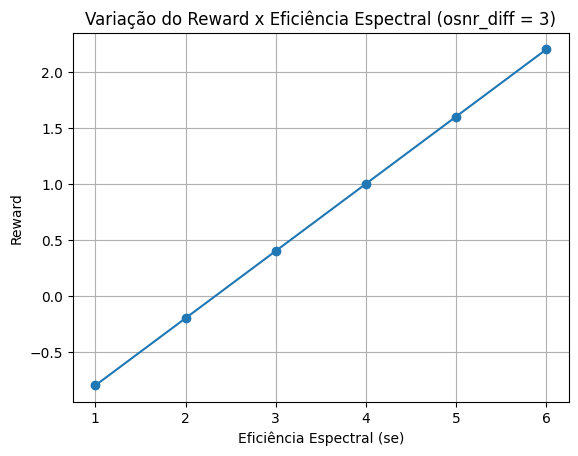

In [34]:
import matplotlib.pyplot as plt

# Variáveis de exemplo
se_values = [1, 2, 3, 4, 5, 6]
diff =8   # Exemplo fixo
alpha = 0.3
beta = 0.6

rewards = []
for se in se_values:
    # Equação: 1.0 - alpha * |diff| + beta * se
    r = 1.0 - alpha * abs(diff) + beta * se
    rewards.append(r)

plt.plot(se_values, rewards, marker='o')
plt.title("Variação do Reward x Eficiência Espectral (osnr_diff = 3)")
plt.xlabel("Eficiência Espectral (se)")
plt.ylabel("Reward")
plt.grid(True)
plt.show()




In [9]:
import pandas as pd
results_ff = pd.read_csv(r"C:\Users\talle\Documents\Mestrado\optical-networking-gym\newgsnr__first_fit_nobel_us_results_20250120_103709.csv")
results_ppo = pd.read_csv(r"results_so_far.csv")

In [7]:
results_ff

,episode,service_blocking_rate,episode_service_blocking_rate,bit_rate_blocking_rate,episode_bit_rate_blocking_rate,modulation_1,modulation_2,modulation_3,modulation_4,modulation_5,modulation_6,episode_disrupted_services,episode_time
0,0,0,0.443443,0.582513,0.582513,0,0,0,0,0,0,0.0,31.10
1,1,0,0.455455,0.551734,0.551734,0,0,0,0,0,0,0.0,27.81
2,2,0,0.440440,0.558978,0.558978,0,0,0,0,0,0,0.0,27.05
3,3,0,0.440440,0.540467,0.540467,0,0,0,0,0,0,0.0,28.08
4,4,0,0.477477,0.581048,0.581048,0,0,0,0,0,0,0.0,29.97


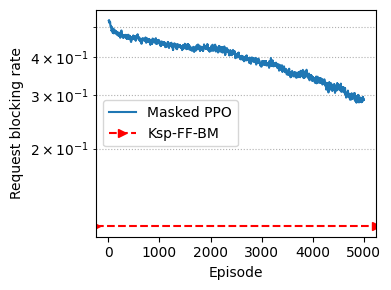

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 3))
plt.plot(
    ((999 - results_ppo["episode_services_accepted"])/ 999).rolling(window=10).mean(),
    label="Masked PPO",
    mec='black',
)

# Plotando a linha horizontal com a média do FF
ff_mean = results_ff["episode_service_blocking_rate"].min()
plt.axhline(
    y=ff_mean,
    color='red',
    linestyle='--',
    marker='>',
    label=f"Ksp-FF-BM",
)

# Configurando os eixos e legendas
plt.xlabel("Episode")
plt.ylabel("Request blocking rate")
plt.gca().set_yscale("log")  # Escala logarítmica para o eixo Y
plt.grid(visible=True, which="major", axis="y", ls="--")  # Grade maior
plt.grid(visible=True, which="minor", axis="y", ls=":")   # Grade menor
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(
    ((999 - results_ppo["episode_bit_rate_accepted"])/ 999).rolling(window=10).mean(),
    label="Masked PPO",
    mec='black',
)

# Plotando a linha horizontal com a média do FF
ff_mean = results_ff["episode_bit_rate_blocking_rate"].min()
plt.axhline(
    y=ff_mean,
    color='red',
    linestyle='--',
    marker='>',
    label=f"Ksp-FF-BM",
)

# Configurando os eixos e legendas
plt.xlabel("Episode")
plt.ylabel("Request blocking rate")
plt.ylim(2* 10**-1, 6 * 10**-1)
plt.gca().set_yscale("log")  # Escala logarítmica para o eixo Y
plt.grid(visible=True, which="major", axis="y", ls="--")  # Grade maior
plt.grid(visible=True, which="minor", axis="y", ls=":")   # Grade menor
plt.legend()
plt.tight_layout()
plt.show()


KeyError: 'episode_bit_rate_accepted'

<Figure size 1000x600 with 0 Axes>

In [73]:
results_ff

,episode,service_blocking_rate,episode_service_blocking_rate,bit_rate_blocking_rate,episode_bit_rate_blocking_rate,modulation_1,modulation_2,modulation_3,modulation_4,modulation_5,modulation_6,episode_disrupted_services,episode_time
0,0,0,0.443443,0.582513,0.582513,0,0,0,0,0,0,0.0,31.10
1,1,0,0.455455,0.551734,0.551734,0,0,0,0,0,0,0.0,27.81
2,2,0,0.440440,0.558978,0.558978,0,0,0,0,0,0,0.0,27.05
3,3,0,0.440440,0.540467,0.540467,0,0,0,0,0,0,0.0,28.08
4,4,0,0.477477,0.581048,0.581048,0,0,0,0,0,0,0.0,29.97


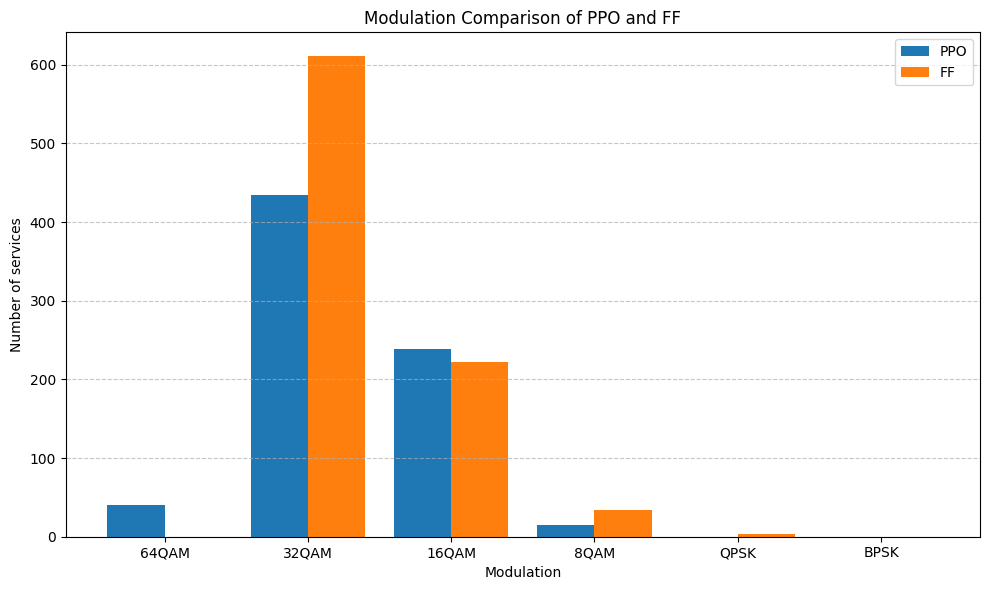

In [13]:
import matplotlib.pyplot as plt

# Simulação de resultados para `results_ppo` e `results_ff` (substitua pelos seus dados reais)
# results_ppo = pd.read_csv("results_ppo.csv")
# results_ff = pd.read_csv("results_ff.csv")

# Seleciona as colunas correspondentes
ppo_columns = [
    "modulation_1.0", "modulation_2.0", "modulation_3.0",
    "modulation_4.0", "modulation_5.0", "modulation_6.0"
]
ff_columns = [
    "modulation_1", "modulation_2", "modulation_3",
    "modulation_4", "modulation_5", "modulation_6"
]

# Lista com os nomes das modulações
modulation_names = [
    "64QAM", "32QAM", "16QAM", "8QAM", "QPSK", "BPSK"
]

# Obtém os valores desejados
ppo_values = results_ppo[ppo_columns].iloc[-1].values  # Última linha do PPO
ff_values = results_ff[ff_columns].mean().values       # Média dos valores do FF

# Configurações para o gráfico
x = range(len(modulation_names))  # Posições no eixo X

# Plotando o gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(x, ppo_values, width=0.4, label="PPO", align='center')
plt.bar(
    [xi + 0.4 for xi in x], ff_values, width=0.4, label="FF", align='center'
)

# Ajustes de rótulos e legendas
plt.xticks([xi + 0.2 for xi in x], modulation_names)  # Usando os nomes das modulações
plt.xlabel("Modulation")
plt.ylabel("Number of services")
plt.title("Modulation Comparison of PPO and FF")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

plt.show()


In [76]:
results_ff

,episode,service_blocking_rate,episode_service_blocking_rate,bit_rate_blocking_rate,episode_bit_rate_blocking_rate,modulation_1,modulation_2,modulation_3,modulation_4,modulation_5,modulation_6,episode_disrupted_services,episode_time
0,0,0,0.443443,0.582513,0.582513,0,0,0,0,0,0,0.0,31.10
1,1,0,0.455455,0.551734,0.551734,0,0,0,0,0,0,0.0,27.81
2,2,0,0.440440,0.558978,0.558978,0,0,0,0,0,0,0.0,27.05
3,3,0,0.440440,0.540467,0.540467,0,0,0,0,0,0,0.0,28.08
4,4,0,0.477477,0.581048,0.581048,0,0,0,0,0,0,0.0,29.97


In [3]:
def get_action_index(path_index: int, modulation_index: int, initial_slot: int) -> int:
    """
    Converte (path_index, modulation_index, initial_slot) em um índice de ação inteiro.
    
    Args:
        env (QRMSAEnv): O ambiente QRMSAEnv.
        path_index (int): Índice da rota.
        modulation_index (int): Índice da modulação.
        initial_slot (int): Slot inicial para alocação.
    
    Returns:
        int: Índice da ação correspondente.
    """
    return path_index * 4 * 15 + \
           modulation_index * 15 + \
           initial_slot

In [5]:
get_action_index(0,1,15)

30

In [ ]:
def is_path_free(arr, initial_slot: int, number_slots: int) -> bool:
    end = initial_slot + number_slots
    if end  > self.num_spectrum_resources:
        return False
    start = initial_slot 
    if end < self.num_spectrum_resources:
        end +=1
    for i in range(len(path.node_list) - 1):
        if np.any(arr[start : end]
                
            ]
            == 0
        ):
            return False
    return True

In [17]:
import numpy as np
arr = [0,0,0,1,0,1,1]
initial_slot = 5
print(len(arr) > initial_slot + 2)
print(arr[initial_slot:initial_slot+2])
print(np.any(np.array(arr[initial_slot:initial_slot+2]) == 0))


False
[1, 1]
False
